In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/archive.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-04

# 導入所需的庫


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# 設定數據集的路徑


In [ ]:
base_dir = './chest_xray'
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

# 數據生成器 - 包含數據增強


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 數據生成器 - 加載訓練和驗證數據


In [ ]:
# 檢查訓練數據集的樣本數
train_sample_count = len(os.listdir(train_dir))
print("訓練樣本數量:", train_sample_count)

# 確保批量大小適當
batch_size = 32
if train_sample_count < batch_size:
    batch_size = train_sample_count
    print("調整後的批量大小:", batch_size)

# 更新數據生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

訓練樣本數量: 2
調整後的批量大小: 2
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# 建立模型架構


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    SeparableConv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    SeparableConv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 編譯模型


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# 設置回調函數


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)


# 檢查和調整批量大小

In [ ]:
print("訓練樣本數量:", train_generator.samples)
batch_size = train_generator.batch_size

if train_generator.samples < batch_size:
    print("調整批量大小")
    batch_size = train_generator.samples  # 調整批量大小為樣本數量

steps_per_epoch = max(train_generator.samples // batch_size, 1)  # 確保不為 0
print("steps_per_epoch 設置為:", steps_per_epoch)

訓練樣本數量: 5216
steps_per_epoch 設置為: 2608


# 訓練模型


In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 這裡的 "0" 表示第一個 GPU

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_generator,
    validation_steps=max(val_generator.samples // batch_size, 1),
    callbacks=[early_stopping, reduce_lr])


Num GPUs Available:  1
Epoch 1/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.6334 - accuracy: 0.6975

2608/2608 [==============================] - 101s 35ms/step - loss: 0.6333 - accuracy: 0.6977 - val_loss: 0.6318 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5812 - accuracy: 0.7217

2608/2608 [==============================] - 91s 35ms/step - loss: 0.5812 - accuracy: 0.7216 - lr: 0.0010
Epoch 3/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.7251

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5820 - accuracy: 0.7251 - lr: 0.0010
Epoch 4/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5689 - accuracy: 0.7275

2608/2608 [==============================] - 92s 35ms/step - loss: 0.5688 - accuracy: 0.7276 - lr: 0.0010
Epoch 5/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5675 - accuracy: 0.7266

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5673 - accuracy: 0.7268 - lr: 0.0010
Epoch 6/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7237

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5709 - accuracy: 0.7237 - lr: 0.0010
Epoch 7/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5740 - accuracy: 0.7237

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5737 - accuracy: 0.7239 - lr: 0.0010
Epoch 8/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.7329

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5590 - accuracy: 0.7329 - lr: 0.0010
Epoch 9/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5526 - accuracy: 0.7394

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5526 - accuracy: 0.7393 - lr: 0.0010
Epoch 10/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.7345

2608/2608 [==============================] - 92s 35ms/step - loss: 0.5512 - accuracy: 0.7345 - lr: 0.0010
Epoch 11/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5446 - accuracy: 0.7367

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5445 - accuracy: 0.7368 - lr: 0.0010
Epoch 12/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.7322

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5487 - accuracy: 0.7322 - lr: 0.0010
Epoch 13/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5383 - accuracy: 0.7413

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5382 - accuracy: 0.7414 - lr: 0.0010
Epoch 14/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5429 - accuracy: 0.7468

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5428 - accuracy: 0.7469 - lr: 0.0010
Epoch 15/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.7418

2608/2608 [==============================] - 92s 35ms/step - loss: 0.5381 - accuracy: 0.7418 - lr: 0.0010
Epoch 16/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.7581

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5218 - accuracy: 0.7581 - lr: 0.0010
Epoch 17/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5350 - accuracy: 0.7453

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5352 - accuracy: 0.7452 - lr: 0.0010
Epoch 18/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.7513

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5309 - accuracy: 0.7513 - lr: 0.0010
Epoch 19/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.7501

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5275 - accuracy: 0.7498 - lr: 0.0010
Epoch 20/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5415 - accuracy: 0.7433

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5415 - accuracy: 0.7433 - lr: 0.0010
Epoch 21/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7400

2608/2608 [==============================] - 93s 36ms/step - loss: 0.5436 - accuracy: 0.7400 - lr: 0.0010
Epoch 22/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7510

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5225 - accuracy: 0.7510 - lr: 0.0010
Epoch 23/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.7599

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5146 - accuracy: 0.7598 - lr: 0.0010
Epoch 24/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.7553

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5128 - accuracy: 0.7552 - lr: 0.0010
Epoch 25/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5124 - accuracy: 0.7616

2608/2608 [==============================] - 90s 35ms/step - loss: 0.5123 - accuracy: 0.7617 - lr: 0.0010
Epoch 26/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5363 - accuracy: 0.7497

2608/2608 [==============================] - 93s 36ms/step - loss: 0.5363 - accuracy: 0.7496 - lr: 0.0010
Epoch 27/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5373 - accuracy: 0.7487

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5372 - accuracy: 0.7487 - lr: 0.0010
Epoch 28/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.7514

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5268 - accuracy: 0.7515 - lr: 0.0010
Epoch 29/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5160 - accuracy: 0.7532

2608/2608 [==============================] - 91s 35ms/step - loss: 0.5159 - accuracy: 0.7533 - lr: 0.0010
Epoch 30/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5143 - accuracy: 0.7570

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5142 - accuracy: 0.7571 - lr: 0.0010
Epoch 31/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5037 - accuracy: 0.7676

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5037 - accuracy: 0.7676 - lr: 0.0010
Epoch 32/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.7634

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5153 - accuracy: 0.7634 - lr: 0.0010
Epoch 33/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.7729

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5041 - accuracy: 0.7728 - lr: 0.0010
Epoch 34/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.7793

2608/2608 [==============================] - 88s 34ms/step - loss: 0.4999 - accuracy: 0.7793 - lr: 0.0010
Epoch 35/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.4957 - accuracy: 0.7769

2608/2608 [==============================] - 88s 34ms/step - loss: 0.4959 - accuracy: 0.7768 - lr: 0.0010
Epoch 36/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.7663

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5008 - accuracy: 0.7665 - lr: 0.0010
Epoch 37/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5016 - accuracy: 0.7661

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5016 - accuracy: 0.7661 - lr: 0.0010
Epoch 38/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5103 - accuracy: 0.7512

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5102 - accuracy: 0.7513 - lr: 0.0010
Epoch 39/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5113 - accuracy: 0.7584

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5113 - accuracy: 0.7584 - lr: 0.0010
Epoch 40/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.7533

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5219 - accuracy: 0.7533 - lr: 0.0010
Epoch 41/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5330 - accuracy: 0.7497

2608/2608 [==============================] - 91s 35ms/step - loss: 0.5332 - accuracy: 0.7496 - lr: 0.0010
Epoch 42/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.7651

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5219 - accuracy: 0.7651 - lr: 0.0010
Epoch 43/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5127 - accuracy: 0.7649

2608/2608 [==============================] - 91s 35ms/step - loss: 0.5128 - accuracy: 0.7648 - lr: 0.0010
Epoch 44/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.7724

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5050 - accuracy: 0.7724 - lr: 0.0010
Epoch 45/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.7682

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5130 - accuracy: 0.7682 - lr: 0.0010
Epoch 46/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.7543

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5202 - accuracy: 0.7544 - lr: 0.0010
Epoch 47/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7542

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5275 - accuracy: 0.7542 - lr: 0.0010
Epoch 48/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.7646

2608/2608 [==============================] - 90s 35ms/step - loss: 0.5078 - accuracy: 0.7646 - lr: 0.0010
Epoch 49/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5378 - accuracy: 0.7488

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5377 - accuracy: 0.7488 - lr: 0.0010
Epoch 50/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.7498

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5282 - accuracy: 0.7498 - lr: 0.0010
Epoch 51/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.7535

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5209 - accuracy: 0.7535 - lr: 0.0010
Epoch 52/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.7542

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5262 - accuracy: 0.7542 - lr: 0.0010
Epoch 53/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5271 - accuracy: 0.7558

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5271 - accuracy: 0.7558 - lr: 0.0010
Epoch 54/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5267 - accuracy: 0.7569

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5265 - accuracy: 0.7571 - lr: 0.0010
Epoch 55/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.7685

2608/2608 [==============================] - 92s 35ms/step - loss: 0.5047 - accuracy: 0.7686 - lr: 0.0010
Epoch 56/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7548

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5225 - accuracy: 0.7548 - lr: 0.0010
Epoch 57/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.7512

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5325 - accuracy: 0.7512 - lr: 0.0010
Epoch 58/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5336 - accuracy: 0.7423

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5334 - accuracy: 0.7425 - lr: 0.0010
Epoch 59/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.7462

2608/2608 [==============================] - 91s 35ms/step - loss: 0.5331 - accuracy: 0.7462 - lr: 0.0010
Epoch 60/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7571

2608/2608 [==============================] - 95s 37ms/step - loss: 0.5161 - accuracy: 0.7571 - lr: 0.0010
Epoch 61/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5101 - accuracy: 0.7660

2608/2608 [==============================] - 99s 38ms/step - loss: 0.5103 - accuracy: 0.7659 - lr: 0.0010
Epoch 62/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5208 - accuracy: 0.7514

2608/2608 [==============================] - 93s 36ms/step - loss: 0.5209 - accuracy: 0.7513 - lr: 0.0010
Epoch 63/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7657

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5135 - accuracy: 0.7657 - lr: 0.0010
Epoch 64/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5118 - accuracy: 0.7653

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5116 - accuracy: 0.7655 - lr: 0.0010
Epoch 65/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5225 - accuracy: 0.7555

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5226 - accuracy: 0.7554 - lr: 0.0010
Epoch 66/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5123 - accuracy: 0.7629

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5121 - accuracy: 0.7630 - lr: 0.0010
Epoch 67/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5005 - accuracy: 0.7713

2608/2608 [==============================] - 91s 35ms/step - loss: 0.5003 - accuracy: 0.7715 - lr: 0.0010
Epoch 68/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.7500

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5102 - accuracy: 0.7500 - lr: 0.0010
Epoch 69/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7573

2608/2608 [==============================] - 90s 34ms/step - loss: 0.5141 - accuracy: 0.7575 - lr: 0.0010
Epoch 70/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5106 - accuracy: 0.7610

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5105 - accuracy: 0.7611 - lr: 0.0010
Epoch 71/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7594

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5217 - accuracy: 0.7594 - lr: 0.0010
Epoch 72/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.7684

2608/2608 [==============================] - 88s 34ms/step - loss: 0.4999 - accuracy: 0.7684 - lr: 0.0010
Epoch 73/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5046 - accuracy: 0.7654

2608/2608 [==============================] - 90s 35ms/step - loss: 0.5045 - accuracy: 0.7655 - lr: 0.0010
Epoch 74/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.4996 - accuracy: 0.7675

2608/2608 [==============================] - 90s 35ms/step - loss: 0.4995 - accuracy: 0.7676 - lr: 0.0010
Epoch 75/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5057 - accuracy: 0.7674

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5056 - accuracy: 0.7674 - lr: 0.0010
Epoch 76/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.7475

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5273 - accuracy: 0.7475 - lr: 0.0010
Epoch 77/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.7745

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4847 - accuracy: 0.7745 - lr: 0.0010
Epoch 78/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4976 - accuracy: 0.7682

2608/2608 [==============================] - 88s 34ms/step - loss: 0.4976 - accuracy: 0.7682 - lr: 0.0010
Epoch 79/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.4900 - accuracy: 0.7710

2608/2608 [==============================] - 92s 35ms/step - loss: 0.4900 - accuracy: 0.7709 - lr: 0.0010
Epoch 80/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.7545

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5044 - accuracy: 0.7542 - lr: 0.0010
Epoch 81/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5053 - accuracy: 0.7657

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5053 - accuracy: 0.7657 - lr: 0.0010
Epoch 82/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.7663

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5036 - accuracy: 0.7663 - lr: 0.0010
Epoch 83/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5026 - accuracy: 0.7643

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5026 - accuracy: 0.7642 - lr: 0.0010
Epoch 84/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.7595

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5173 - accuracy: 0.7594 - lr: 0.0010
Epoch 85/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7611

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5071 - accuracy: 0.7611 - lr: 0.0010
Epoch 86/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.7663

2608/2608 [==============================] - 91s 35ms/step - loss: 0.4930 - accuracy: 0.7665 - lr: 0.0010
Epoch 87/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.7676

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4966 - accuracy: 0.7676 - lr: 0.0010
Epoch 88/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.4844 - accuracy: 0.7779

2608/2608 [==============================] - 90s 34ms/step - loss: 0.4845 - accuracy: 0.7778 - lr: 0.0010
Epoch 89/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4997 - accuracy: 0.7759

2608/2608 [==============================] - 88s 34ms/step - loss: 0.4997 - accuracy: 0.7759 - lr: 0.0010
Epoch 90/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.7847

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4949 - accuracy: 0.7847 - lr: 0.0010
Epoch 91/100
2608/2608 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7665

2608/2608 [==============================] - 91s 35ms/step - loss: 0.5059 - accuracy: 0.7665 - lr: 0.0010
Epoch 92/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.7568

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5145 - accuracy: 0.7569 - lr: 0.0010
Epoch 93/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.4987 - accuracy: 0.7642

2608/2608 [==============================] - 91s 35ms/step - loss: 0.4987 - accuracy: 0.7642 - lr: 0.0010
Epoch 94/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.4952 - accuracy: 0.7707

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4951 - accuracy: 0.7707 - lr: 0.0010
Epoch 95/100
2606/2608 [============================>.] - ETA: 0s - loss: 0.4804 - accuracy: 0.7746

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4804 - accuracy: 0.7745 - lr: 0.0010
Epoch 96/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.4817 - accuracy: 0.7716

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4815 - accuracy: 0.7717 - lr: 0.0010
Epoch 97/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5097 - accuracy: 0.7582

2608/2608 [==============================] - 89s 34ms/step - loss: 0.5097 - accuracy: 0.7581 - lr: 0.0010
Epoch 98/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.7624

2608/2608 [==============================] - 88s 34ms/step - loss: 0.5027 - accuracy: 0.7625 - lr: 0.0010
Epoch 99/100
2607/2608 [============================>.] - ETA: 0s - loss: 0.4826 - accuracy: 0.7722

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4825 - accuracy: 0.7722 - lr: 0.0010
Epoch 100/100
2608/2608 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.7717

2608/2608 [==============================] - 89s 34ms/step - loss: 0.4864 - accuracy: 0.7717 - lr: 0.0010


# 儲存模型


In [12]:
model.save('optimized_pneumonia_model.keras')


# 可視化訓練結果

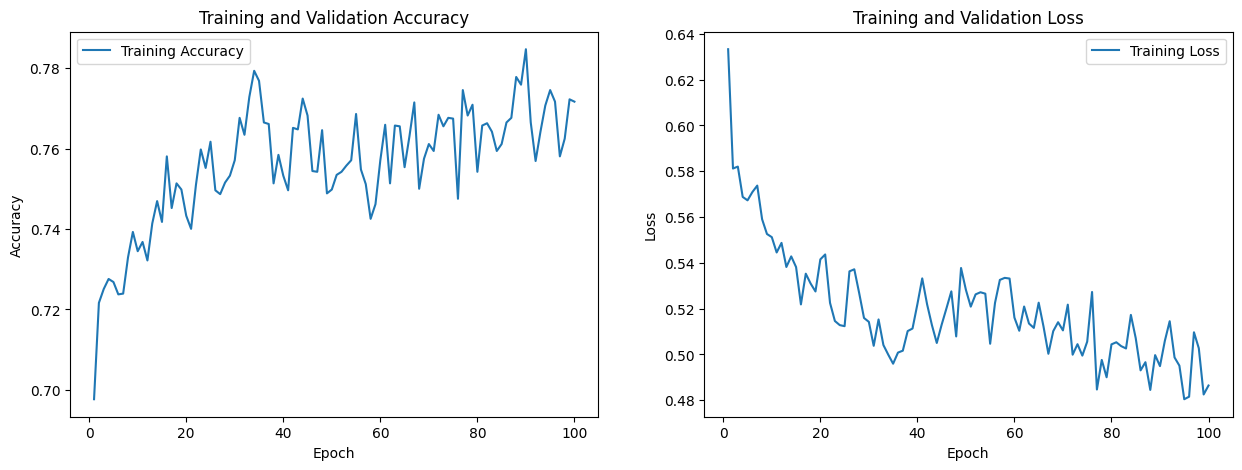

In [13]:
import matplotlib.pyplot as plt

# 假設 history 變量已包含模型的訓練歷史
# 取得訓練和驗證的準確率
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 取得訓練和驗證的損失值
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# 繪製準確率和損失值
plt.figure(figsize=(15, 5))

# 繪製準確率
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 繪製損失值
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# 混淆矩陣

1/1 [==============================] - 0s 421ms/step


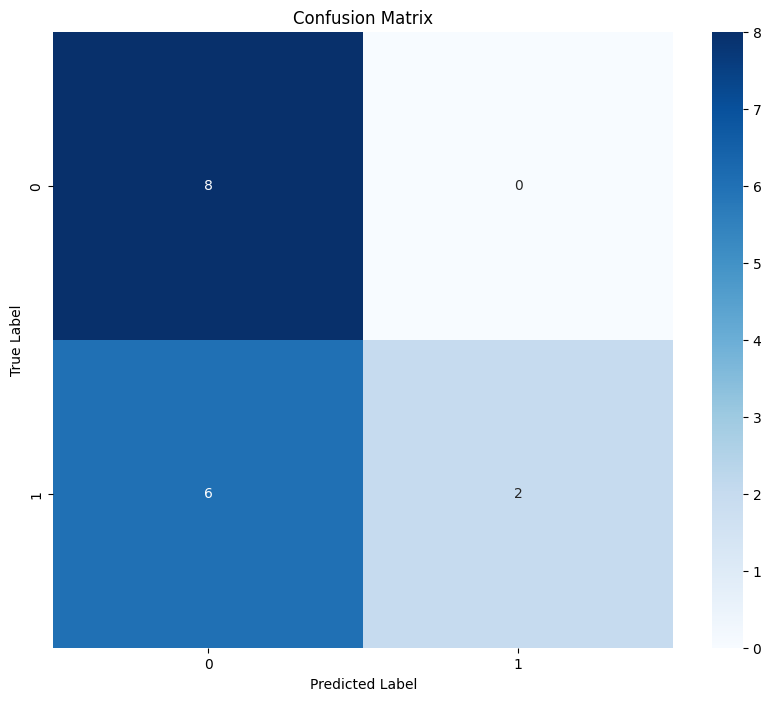

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 從驗證集獲取真實標籤
val_labels = val_generator.classes

# 從驗證集獲取預測結果
val_predictions = model.predict(val_generator)
val_predictions = np.round(val_predictions).astype(int).flatten()

# 計算混淆矩陣
conf_matrix = confusion_matrix(val_labels, val_predictions)

# 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 創建性能指標柱狀圖

1/1 [==============================] - 0s 229ms/step - loss: 8.4712 - accuracy: 0.6250


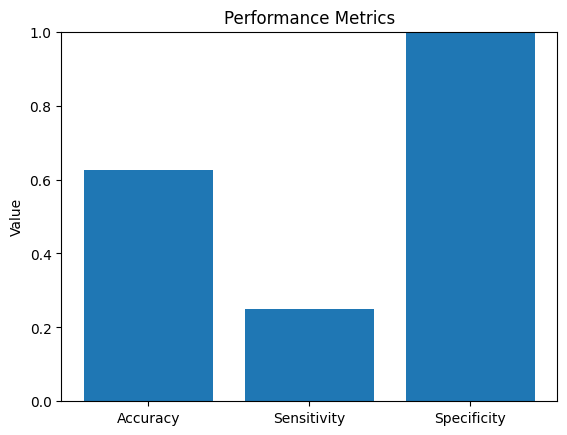

In [15]:
import matplotlib.pyplot as plt

# 提取混淆矩陣的元素
tn, fp, fn, tp = conf_matrix.ravel()

# 計算敏感度和特異性
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# 繪製柱狀圖
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
values = [model.evaluate(val_generator)[1], sensitivity, specificity]

plt.bar(metrics, values)
plt.title('Performance Metrics')
plt.ylim(0, 1)
plt.ylabel('Value')
plt.show()
